# Neural network for binary classification of male & female voice
### HSE student: Daria Diatlova

In [ ]:
!pip install torchaudio

In [ ]:
!pip install pytorch_lightning

In [150]:
from typing import Union, List, Tuple
import torch
import torchaudio
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset,TensorDataset, DataLoader
from pytorch_lightning import metrics
import requests
import matplotlib.pyplot as plt
import numpy as np
import os 
import random
from scipy import signal, arange
from scipy.fftpack import fft, fftshift
from scipy.io import wavfile
import IPython.display as ipd
import librosa
import librosa.display

In [143]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
SEED = 7
np.random.seed(SEED)
random.seed(SEED)

## DATA PREPARATION SECTION

In [112]:
frf01 = os.listdir('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frf01')
frf02 = os.listdir('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frf02')
frf03 = os.listdir('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frf03')
frf04 = os.listdir('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frf04')
frm01 = os.listdir('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frm01')
frm02 = os.listdir('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frm02')
frm03 = os.listdir('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frm03')
frm04 = os.listdir('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frm04')
audio = np.array([frf01, frf02, frf03, frf04, frm01, frm02, frm03, frm04])
names = np.array(['frf01/', 'frf02/', 'frf03/', 'frf04/', 
                  'frm01/', 'frm02/', 'frm03/', 'frm04/'])

In [ ]:
w_frf01 = os.listdir('/content/drive/MyDrive/Colab Notebooks/Huawei/whsp/data/whsp/frf01')
w_frm01 = os.listdir('/content/drive/MyDrive/Colab Notebooks/Huawei/whsp/data/whsp/frm01')
w_audio = np.array([frf01, frf02])
w_names = np.array(['frf01/', 'frf02/'])

In [123]:
def preprocessing(audio: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    X_data = audio[0]
    y_data = np.ones_like(audio[0], dtype=np.int)
    directories = np.full(len(y_data), names[0])

    for i, x in enumerate(audio[1:]):
        if i <= 2:
            y = np.ones_like(x) # label female data as '1'
        else:
            y = np.zeros(len(x), dtype=np.int32) # label female data as '2'

        y_data = np.concatenate((y_data, y))
        X_data = np.concatenate((X_data, x))
        name = np.full(len(y), names[i + 1])
        directories = np.concatenate((directories, name))

    return X_data, y_data, directories


In [190]:
def split_data(X: np.ndarray, y: np.ndarray, directories: np.ndarray) -> (
    Tuple[np.ndarray, np.ndarray, np.ndarray, 
          np.ndarray, np.ndarray, np.ndarray]):
  
    train_size = np.int32(X_data.shape[0] * 0.8)
    train_indecies = np.random.choice(X_data.shape[0], train_size, replace=False) 
    val_indecies = np.array([i for i in np.arange(X_data.shape[0]) if i not in train_indecies])

    train_rec = X_data[train_indecies]
    train_labels = y_data[train_indecies]
    train_directories = directories[train_indecies]

    val_rec = X_data[val_indecies]
    val_labels = y_data[val_indecies]
    val_directories = directories[val_indecies]

    print(np.sort(train_indecies), val_indecies)

    return (train_rec, train_labels, train_directories,
            val_rec, val_labels, val_directories)
    

In [129]:
def find_split_feature(samples: np.ndarray, dir: np.ndarray, path) -> np.int32:
    split_feature = np.inf
    for i, filename in enumerate(samples):
        waveform = torchaudio.load(path + dir[i] + filename)[0]
        if split_feature > waveform.shape[1]:
            split_feature = waveform.shape[1]
    return split_feature

In [98]:
def load_audio(samples: np.ndarray, dir: np.ndarray, path, split_feature: np.int32) -> (
    Tuple[torch.tensor, torch.tensor]):
    waveforms = torch.empty(samples.shape[0], split_feature)
    sample_rates = torch.empty(samples.shape[0], 1)
    for i, filename in enumerate(samples):
        waveform, sample_rate = torchaudio.load(path + dir[i] + filename)
        waveforms[i] = waveform[:, :split_feature]
        sample_rates[i] = sample_rate
    return waveforms, sample_rates


In [136]:
mfcc_module = (torchaudio.transforms.MFCC(
    sample_rate=22050, n_mfcc=10, melkwargs={"n_fft": 2048, "hop_length": 4098, "power": 2}))

def reshaping(X: torch.tensor) -> torch.tensor:
    return X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

def mfcc_transformation(X: torch.tensor, y: np.ndarray, batch_size=8) -> (
    torch.utils.data.dataloader.DataLoader):
    data = (TensorDataset(reshaping(mfcc_module(X)), 
                            torch.tensor(y.astype(np.int32).reshape(y.shape[0], 1))))
    data_loader = DataLoader(data, shuffle=True, batch_size=batch_size)
    return data_loader


In [ ]:
X, y, directories = preprocessing(audio)
train_rec, train_labels, train_directories = split_data(X, y, directories)[:3]
val_rec, val_labels, val_directories = split_data(X, y, directories)[3:]

path = '/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/'
sf_train = find_split_feature(train_rec, train_directories, path)
sf_val = find_split_feature(val_rec, val_directories, path)
sf = min(sf_train, sf_val)

waveforms_train, sample_rates_train = load_audio(train_rec, train_directories, sf)
waveforms_val, sample_rates_val = load_audio(val_rec, val_directories, sf)

data_loader_train = mfcc_transformation(waveforms_train, train_labels)
data_loader_val = mfcc_transformation(waveforms_val, val_labels)

## SPECTOGRAM VIEW

Shape of waveform: torch.Size([38849])
Sample rate of waveform: tensor([44100.])


Text(0.08, 0.5, 'Waveform')

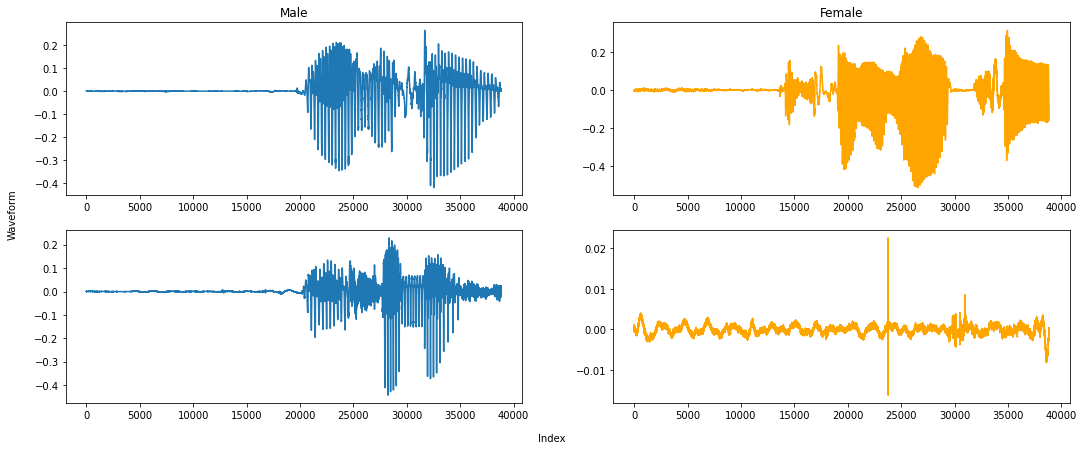

In [144]:
print("Shape of waveform: {}".format(waveforms_train[0].size()))
print("Sample rate of waveform: {}".format(sample_rates_train[0]))

fig, axs = plt.subplots(2, 2, figsize=(18, 7))
axs[0, 0].set_title('Male')
axs[0, 0].plot(waveforms_train[2].t().numpy())
axs[0, 1].set_title('Female')
axs[0, 1].plot(waveforms_train[0].t().numpy(), 'orange')
axs[1, 0].plot(waveforms_train[4].t().numpy())
axs[1, 1].plot(waveforms_train[1].t().numpy(), 'orange')
fig.text(0.5, 0.05, 'Index', ha='center')
fig.text(0.08, 0.5, 'Waveform', va='center', rotation='vertical')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.


Text(0.08, 0.5, '|X(freq)|')

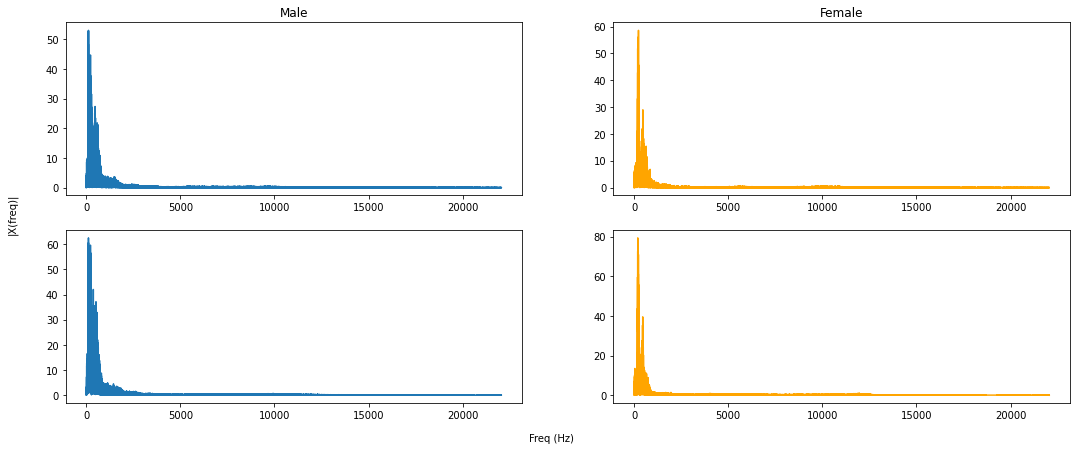

In [147]:
def frequency_spectr(w: np.ndarray, sf: np.ndarray):
    w = w - np.average(w)  # zero-centering
    n = len(w)
    k = arange(n)
    tarr = n / float(sf)
    frqarr = k / float(tarr)  # two sides frequency range
    frqarr = frqarr[range(n // 2)]  # one side frequency range
    w = fft(w) / n  # fft computing and normalization
    w = w[range(n // 2)]
    return frqarr, abs(w)

srf1, signalf1 = wavfile.read('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frf01/frf01_f01_fast.wav')
srm1, signalm1 = wavfile.read('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frm03/frm03_f01_fast.wav')
srf2, signalf2 = wavfile.read('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frf01/frf01_f02_fast.wav')
srm2, signalm2 = wavfile.read('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frm03/frm03_f02_fast.wav')

frqf1, Xf1 = frequency_spectr(np.array(signalf1), np.array(srf1))
frqm1, Xm1 = frequency_spectr(np.array(signalm1), np.array(srm1))
frqf2, Xf2 = frequency_spectr(np.array(signalf2), np.array(srf2))
frqm2, Xm2 = frequency_spectr(np.array(signalm2), np.array(srm2))

fig, axs = plt.subplots(2, 2, figsize=(18, 7))
axs[0, 0].set_title('Male')
axs[0, 0].plot(frqm1, Xm1)
axs[0, 1].set_title('Female')
axs[0, 1].plot(frqf1, Xf1, 'orange')
axs[1, 0].plot(frqm2, Xm2)
axs[1, 1].plot(frqf2, Xf2, 'orange')
fig.text(0.5, 0.05, 'Freq (Hz)', ha='center')
fig.text(0.08, 0.5, '|X(freq)|', va='center', rotation='vertical')


In [148]:
print('Male audio sample:')
ipd.Audio('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frm03/frm03_f01_fast.wav')

Output hidden; open in https://colab.research.google.com to view.

In [149]:
print('Female audio sample:')
ipd.Audio('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frf01/frf01_f01_fast.wav')

Output hidden; open in https://colab.research.google.com to view.

In [161]:
def plot(parameter):
    plt.figure(figsize=(18, 4))
    librosa.display.specshow(parameter, x_axis="time", sr=srm)
    plt.colorbar(format="%+2f")
    plt.show()

MFCCS - Male and Female audio sample

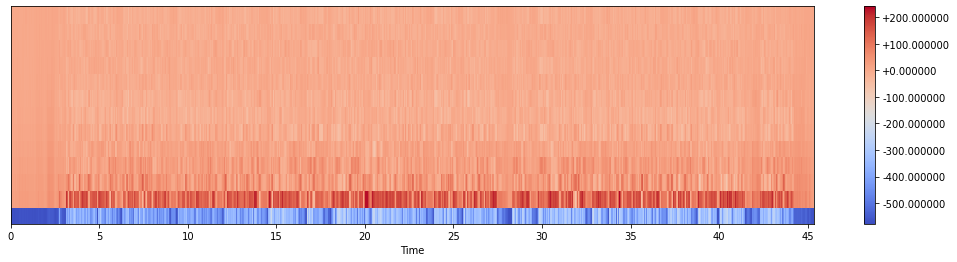

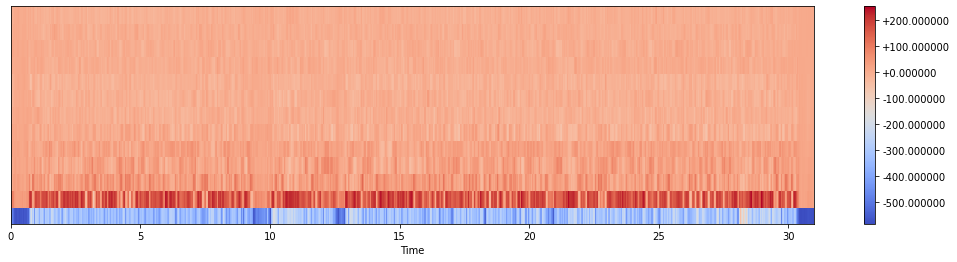

In [162]:
signalf, srf = librosa.load('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frf01/frf01_f01_fast.wav')
signalm, srm = librosa.load('/content/drive/MyDrive/Colab Notebooks/Huawei/fast/data/fast/frm03/frm03_f01_fast.wav')
mfccsm = librosa.feature.mfcc(signalf, n_mfcc=13, sr=srf)
mfccsf = librosa.feature.mfcc(signalm, n_mfcc=13, sr=srm)

plot(mfccsm)
plot(mfccsf)

First derivative of MFCCS – Male and Female audio sample

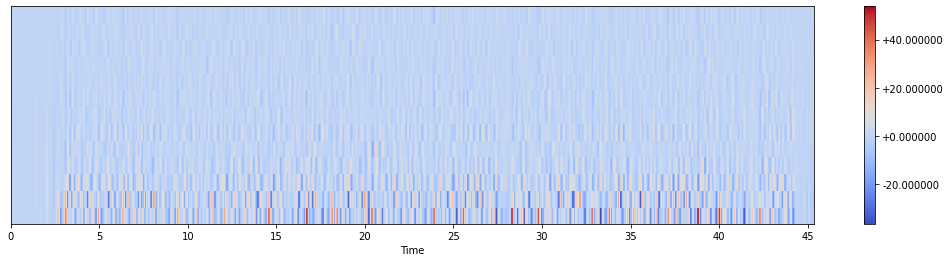

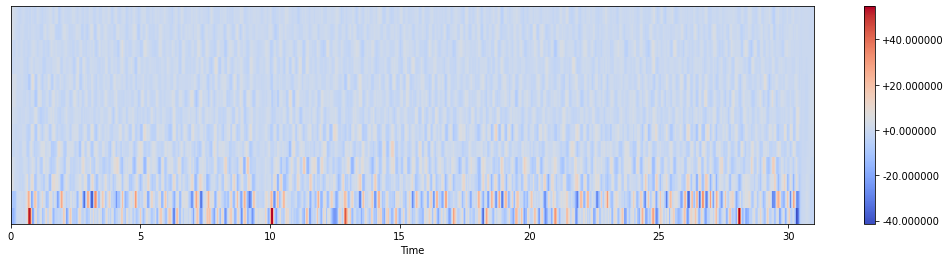

In [163]:
delta_mfccsm = librosa.feature.delta(mfccsm)
delta_mfccsf = librosa.feature.delta(mfccsf)

plot(delta_mfccsm)
plot(delta_mfccsf)

Second derivative of MFCCS – Male and Female audio sample

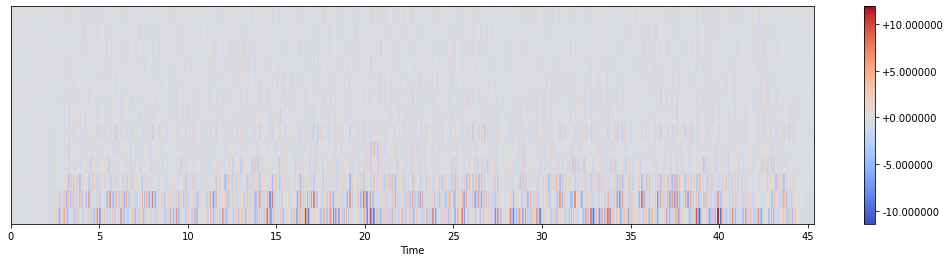

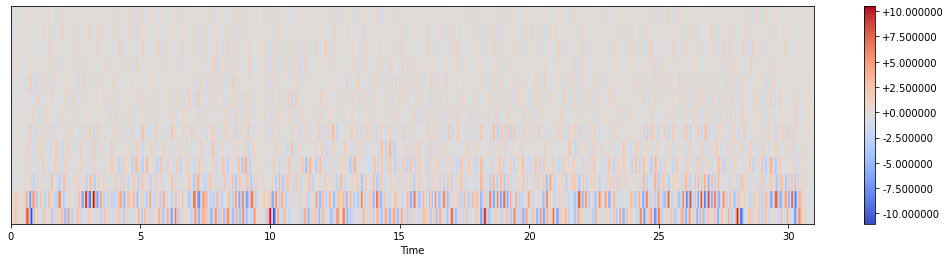

In [165]:
delta2_mfccsm = librosa.feature.delta(delta_mfccsm)
delta2_mfccsf = librosa.feature.delta(delta_mfccsf)

plot(delta2_mfccsm)
plot(delta2_mfccsf)

## MODEL IMPLEMENTATION

In [182]:
class Model(nn.Module):    
    
    def __init__(self, channels=8, latent_size=10, samplings=4, out_channels=1):       
        super().__init__() 
        modules = [nn.Conv2d(latent_size, channels, kernel_size=1, stride=1, padding=0)]
        for i in range(samplings):
            channels *= 2
            modules += [nn.Conv2d(channels//2, channels, kernel_size=3, stride=2, padding=1),
                           nn.BatchNorm2d(channels),
                           nn.ReLU()]
        modules += [nn.Conv2d(channels, channels*2, kernel_size=3, stride=2, padding=1),
                   nn.Dropout(p=0.2),
                   nn.Flatten(),
                   nn.Linear(channels*2, out_channels)]
        self.sigmoid = nn.Sigmoid()
        self.layers = nn.Sequential(*modules)

        
    def forward(self, x: torch.Tensor) -> torch.Tensor:  
        return self.sigmoid(self.layers(x))

In [167]:
Model()

Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Conv2d(10, 8, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): Dropout(p=0.2, inplace=False)
    (15): Flatten(start_dim=1, end_dim=-1)
   

In [193]:
def calculate_loss(X: torch.Tensor, y: torch.Tensor, model: Model):
    loss = nn.BCELoss()
    predictions = model.forward(X)
    return loss((predictions), y.type_as(predictions))

def train(model: Model, max_epochs=151):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    train_accuracy = metrics.Accuracy()
    valid_accuracy = metrics.Accuracy(compute_on_step=False)
    for epoch in range(max_epochs):  

        # Train
        for X, y in data_loader_train:
            y_hat = model(X)
            batch_acc = train_accuracy(y_hat, y)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

        # Val  
        with torch.set_grad_enabled(False):         
            for X, y in data_loader_val:
                y_hat = model(X)
                valid_accuracy(y_hat, y)
                loss = calculate_loss(X, y, model)
        total_train_accuracy = train_accuracy.compute()
        total_valid_accuracy = valid_accuracy.compute()
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, | Train accuracy: {total_train_accuracy}, Validation accuracy, {total_valid_accuracy}")                 
    return 
                  
model = Model()
train(model)

Epoch: 0, | Train accuracy: 0.6610169410705566, Validation accuracy, 0.8166666626930237
Epoch: 10, | Train accuracy: 0.8840523958206177, Validation accuracy, 0.8696969747543335
Epoch: 20, | Train accuracy: 0.9134382605552673, Validation accuracy, 0.9015873074531555
Epoch: 30, | Train accuracy: 0.9264625310897827, Validation accuracy, 0.9198924899101257
Epoch: 40, | Train accuracy: 0.9354072213172913, Validation accuracy, 0.9341463446617126
Epoch: 50, | Train accuracy: 0.9413426518440247, Validation accuracy, 0.9369280934333801
Epoch: 60, | Train accuracy: 0.946999192237854, Validation accuracy, 0.9423497319221497
Epoch: 70, | Train accuracy: 0.9515994191169739, Validation accuracy, 0.9448356628417969
Epoch: 80, | Train accuracy: 0.9545930027961731, Validation accuracy, 0.9491769671440125
Epoch: 90, | Train accuracy: 0.9532501101493835, Validation accuracy, 0.9478021860122681
Epoch: 100, | Train accuracy: 0.9506208896636963, Validation accuracy, 0.9465346336364746
Epoch: 110, | Train ac

# INFERENCE SECTION

The reserach task we set for this work was building a binary classifier for male and female voice. As one of the possible solutions, we came up with an idea of building convolutional neural network that would take as input MFCCs of waveform audio signal. For training and validation data the CHAINS Speech Corpus FAST audio recordings were used. The resulting model shows 95.4% accuracy on validation dataset.

As a futher experiment the model could be trained on more number of epochs, however before increasing the number of epochs we suggest to look at the loss in order to avoid overfitting. We would also like to test the model on CHAINS Speech Corpus WISPER and SOLO audio recordings; create the mix dataset using FAST recordings in case of low performance on testing and train the model again. 

The audio quality of dataset the existing model was trained on is quite high. So, we would also be interested in running experiments with noiser data, use wider varaity of preprocessing technics and train the model on more 'real to world' audio-recordings.